In [1]:
from read_data import read_clean_dataset
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = read_clean_dataset()
df.shape

(69394, 17)

In [4]:
df.columns

Index(['ID', 'Caracteristicas', 'Habitaciones', 'Aseos', 'Terraza', 'Piscina',
       'Garaje', 'Precio', 'Metros', 'CodigoPostal', 'Latitud', 'Longitud',
       'NPRO', 'NCA', 'NMUN', 'PrecioM2', 'CUDIS'],
      dtype='object')

In [5]:
df["Caracteristicas"].value_counts()

Caracteristicas
Apartment       52497
House           15509
CountryHouse     1388
Name: count, dtype: int64

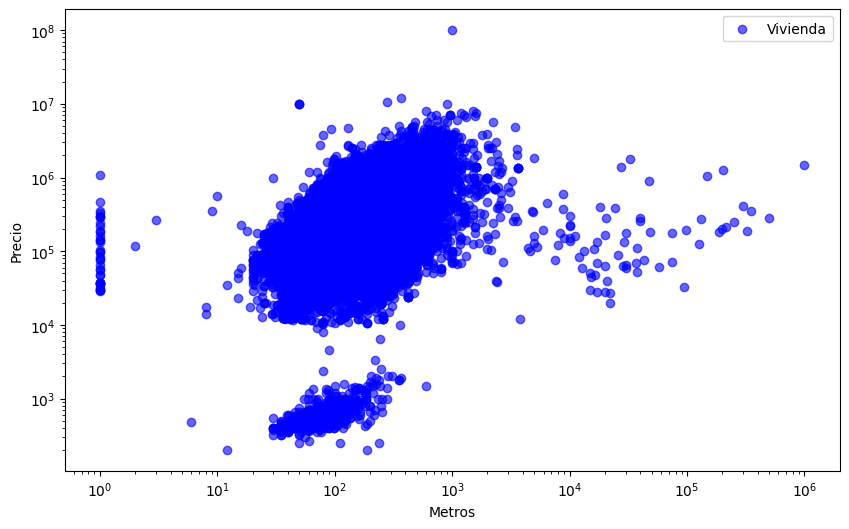

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Metros'], df['Precio'], c='blue', label='Vivienda', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Metros')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [8]:
df_PrecioM2MedioCP=df.groupby('CodigoPostal')['PrecioM2'].median().to_frame('PrecioM2MedioCP').reset_index()
df_PrecioM2MedioCP

,CodigoPostal,PrecioM2MedioCP
0,08001,3511.627907
1,08002,3962.906058
2,08003,4477.514368
3,08004,3612.267453
4,08005,4375.000000
...,...,...
992,43893,2057.843137
993,43894,794.117647
994,43895,1471.428571
995,43896,684.669841


In [9]:
#Creacion del precio del metro cuadrado medio del codigo postal
df=pd.merge(df, df_PrecioM2MedioCP, how='left', on="CodigoPostal")

In [10]:
#Creacion de nuevas metricas
df['Metros/Hab'] = np.where(df['Metros'] / df['Habitaciones'] < 1, 1 / (df['Metros'] / df['Habitaciones']), df['Metros'] / df['Habitaciones'])
df['Aseos/Habitaciones'] = np.where(df['Aseos'] / df['Habitaciones'] < 1, 1 / (df['Aseos'] / df['Habitaciones']), df['Aseos'] / df['Habitaciones'])
df['PrecioM2/PrecioM2MedioCP'] = np.where(df['PrecioM2'] / df['PrecioM2MedioCP'] < 1, 1 / (df['PrecioM2'] / df['PrecioM2MedioCP']), df['PrecioM2'] / df['PrecioM2MedioCP'])

In [11]:
df['Log_PrecioM2/PrecioM2MedioCP'] = np.log(df['PrecioM2/PrecioM2MedioCP'] + 1)

# z-score 
mean = df['Log_PrecioM2/PrecioM2MedioCP'].mean()
std_dev = df['Log_PrecioM2/PrecioM2MedioCP'].std()
df['z_score'] = (df['Log_PrecioM2/PrecioM2MedioCP'] - mean) / std_dev

# threshold para deteccion de anomalias
threshold = 3
df['anomaly'] = df['z_score'].abs() > threshold

In [12]:
df['anomaly'].value_counts()

anomaly
False    68560
True       834
Name: count, dtype: int64

In [13]:
normal_data = df[df['anomaly'] == False]
anomalies = df[df['anomaly'] == True]

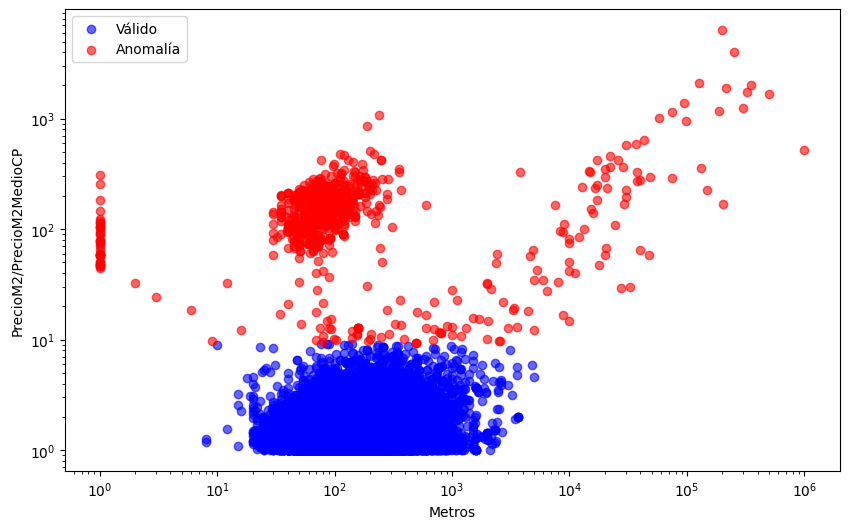

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(normal_data['Metros'], normal_data['PrecioM2/PrecioM2MedioCP'], c='blue', label='Válido', alpha=0.6)
plt.scatter(anomalies['Metros'], anomalies['PrecioM2/PrecioM2MedioCP'], c='red', label='Anomalía', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Metros')
plt.ylabel('PrecioM2/PrecioM2MedioCP')
plt.legend()
plt.show()

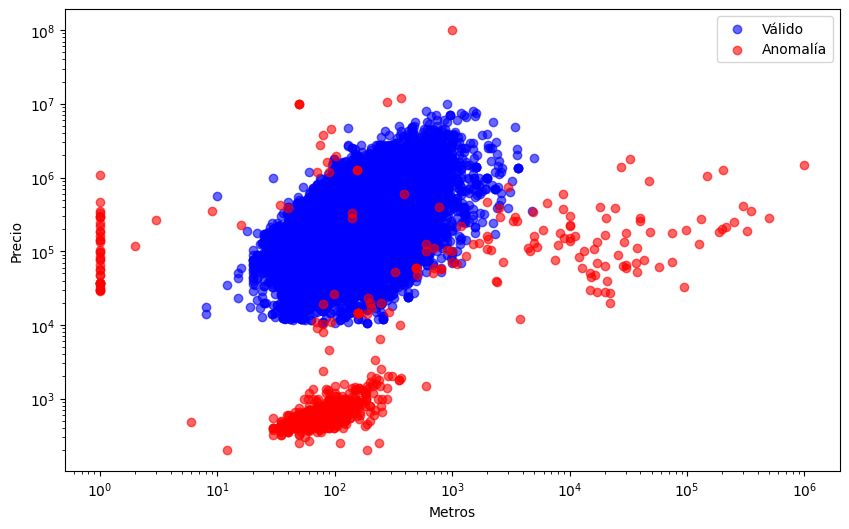

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(normal_data['Metros'], normal_data['Precio'], c='blue', label='Válido', alpha=0.6)
plt.scatter(anomalies['Metros'], anomalies['Precio'], c='red', label='Anomalía', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Metros')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [16]:
normal_data.reset_index(inplace=True)

In [17]:
df_filtered= normal_data[["Aseos/Habitaciones","Habitaciones", "Aseos"]]
df_filtered

,Aseos/Habitaciones,Habitaciones,Aseos
0,1.000000,1,1
1,3.000000,3,1
2,2.000000,4,2
3,2.000000,2,1
4,2.000000,4,2
...,...,...,...
68555,1.000000,2,2
68556,1.500000,3,2
68557,4.000000,4,1
68558,1.333333,4,3


In [18]:
scaler = StandardScaler()
df_filtered_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), columns=df_filtered.columns)
df_filtered_scaled["Aseos/Habitaciones"] = df_filtered_scaled["Aseos/Habitaciones"] * 2

In [19]:
iso_forest = IsolationForest(contamination=0.005, random_state=234)  # Ajuste contaminacion 
df_filtered_an=df_filtered_scaled.copy()
df_filtered_an['anomaly_room'] = iso_forest.fit_predict(df_filtered_scaled)

In [20]:
normal_data['anomaly_room'] = df_filtered_an['anomaly_room']
normal_data['anomaly_room'].value_counts()

C:\Users\emebe\AppData\Local\Temp\ipykernel_5012\1520181914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['anomaly_room'] = df_filtered_an['anomaly_room']


anomaly_room
 1    68228
-1      332
Name: count, dtype: int64

In [21]:
normal_data[normal_data['anomaly_room']==-1][["Aseos/Habitaciones","Habitaciones", "Aseos"]].describe()

,Aseos/Habitaciones,Habitaciones,Aseos
count,332.000000,332.000000,332.000000
mean,24.068549,14.771084,57.385542
std,244.567662,56.004170,674.534846
min,1.000000,1.000000,1.000000
25%,1.172078,8.000000,5.000000
50%,1.666667,10.000000,6.000000
75%,3.031250,11.000000,8.000000
max,3987.666667,999.000000,11963.000000


In [22]:
normal_data[normal_data['anomaly_room']==1][["Aseos/Habitaciones","Habitaciones", "Aseos"]].describe()

,Aseos/Habitaciones,Habitaciones,Aseos
count,68228.000000,68228.000000,68228.000000
mean,2.059682,3.078545,1.693762
std,0.832487,1.135816,0.870442
min,1.000000,1.000000,1.000000
25%,1.500000,2.000000,1.000000
50%,2.000000,3.000000,2.000000
75%,3.000000,4.000000,2.000000
max,7.000000,10.000000,11.000000


In [23]:
normal_data[(normal_data["Habitaciones"]>20)|(normal_data["Aseos"]>20)][["Metros/Hab", "Aseos/Habitaciones","PrecioM2/PrecioM2MedioCP", "Habitaciones", "Aseos", 
                                              "Metros", "Precio", "Caracteristicas", "anomaly", "anomaly_room"]]

,Metros/Hab,Aseos/Habitaciones,PrecioM2/PrecioM2MedioCP,Habitaciones,Aseos,Metros,Precio,Caracteristicas,anomaly,anomaly_room
6686,1.283333,60.000000,1.381798,60,1,77,35500,Apartment,False,-1
12247,4.793651,21.000000,1.311258,63,3,302,770000,House,False,-1
12335,48.000000,3.125000,1.282141,25,8,1200,1290000,CountryHouse,False,-1
12657,39.400000,3.125000,1.561999,25,8,985,1290000,CountryHouse,False,-1
12881,48.000000,3.125000,1.282141,25,8,1200,1290000,House,False,-1
13312,30.952381,1.400000,1.056213,21,15,650,850000,House,False,-1
15550,51.818182,2.750000,1.956330,22,8,1140,2000000,House,False,-1
16032,38.750000,9.000000,1.148014,4,36,155,245900,House,False,-1
17286,1.072917,51.500000,1.045333,103,2,96,75000,Apartment,False,-1
20714,4.354839,31.000000,1.060470,31,1,135,159900,House,False,-1


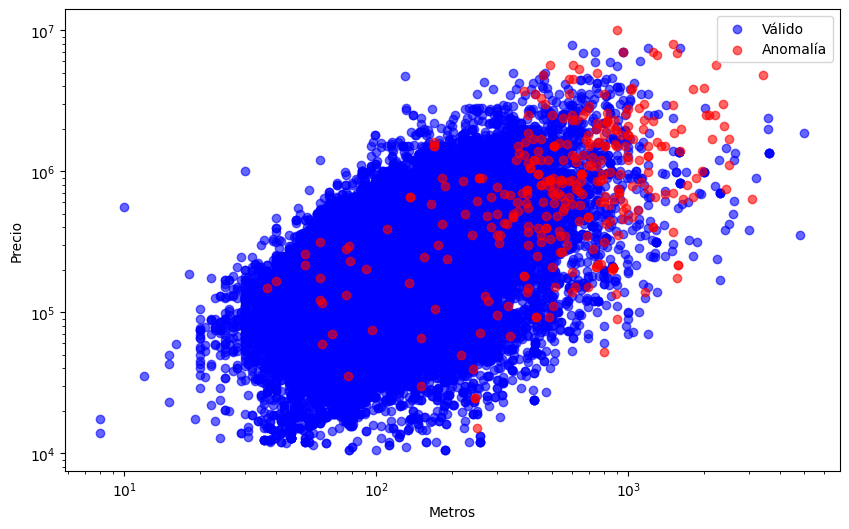

In [25]:
# Separar anomalies y no anomalias
normal_data_2 = normal_data[normal_data['anomaly_room'] == 1]
anomalies_2 = normal_data[normal_data['anomaly_room'] == -1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data_2['Metros'], normal_data_2['Precio'], c='blue', label='Válido', alpha=0.6)
plt.scatter(anomalies_2['Metros'], anomalies_2['Precio'], c='red', label='Anomalía', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Metros')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [ ]:
normal_data_2.describe().T

In [ ]:
normal_data_2.to_csv("output/anomaly_detection.csv")

In [ ]:
normal_data_2.shape